In [504]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pickle
import re

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    PowerTransformer, StandardScaler, OneHotEncoder, 
    OrdinalEncoder, MinMaxScaler, KBinsDiscretizer, 
    PolynomialFeatures
)
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.impute import KNNImputer
from sklearn.metrics import (
    accuracy_score, mean_absolute_error, mean_squared_error, 
    r2_score
)
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from scipy import stats
from sklearn.mixture import GaussianMixture
from xgboost import XGBRegressor
from ydata_profiling import ProfileReport

warnings.filterwarnings("ignore")

In [505]:
# Load data
excel_file_path = "../data/Nigeria_1997-2024_Sep20.csv"
df = pd.read_csv(excel_file_path, encoding="latin-1")

In [506]:
# df['fatalities'] = df['fatalities'] ** 2
# sns.histplot(df['fatalities'], kde=True, bins=30)
# df[df['assoc_actor_1'].isnull()].sample(10).to_csv("anal.csv", index=False)
# mask = df[df['notes'].str.contains('muslim', case=False, na=False) & df['assoc_actor_1'].isnull()].to_csv("anal.csv", index=False)

In [507]:
def remove_outliers(df, outlier_dict):
    for distribution, category in outlier_dict.items():
        if distribution == "normal":
            for cat in category:
                upper_limit = df[cat].mean() + 3 * df[cat].std()
                lower_limit = df[cat].mean() - 3 * df[cat].std()
                print(cat, upper_limit, lower_limit)
                # capping
                # df[cat] = np.where(df[cat] > upper_limit,upper_limit,np.where(df[cat] < lower_limit, lower_limit, df[cat]))
                # Trimming
                df = df[(df[cat] < upper_limit) & (df[cat] > lower_limit)]
        elif distribution == "skew":
            for cat in category:
                percentile25 = df[cat].quantile(0.25)
                percentile75 = df[cat].quantile(0.75)
                iqr = percentile75 - percentile25
                upper_limit = percentile75 + 1.5 * iqr
                lower_limit = percentile25 - 1.5 * iqr
                print(cat, upper_limit, lower_limit)
                # capping
                # df[cat] = np.where(
                #     df[cat] > upper_limit,
                #     upper_limit,
                #     np.where(df[cat] < lower_limit, lower_limit, df[cat]),
                # )
                # Trimming
                df = df[(df[cat] < upper_limit) & (df[cat] > lower_limit)]
    return df

In [508]:
from sklearn.cluster import DBSCAN


outlier_dict = {
    "normal": [],
    "skew": [],
}

def frequency_encoding(df, columns):
        for col in columns:
            freq_encoding = df[col].value_counts() / len(df)
            name = col + "_freq"
            df[name] = df[col].map(freq_encoding)
        return df

def perform_dbscan_and_plot(df, eps=0.17, min_samples=4):
    """
    Perform DBSCAN clustering on latitude and longitude data and plot the resulting clusters.

    Parameters:
    - df (DataFrame): The DataFrame containing 'latitude' and 'longitude' columns.
    - eps (float): The maximum distance between two points for them to be considered as in the same neighborhood.
    - min_samples (int): The minimum number of points to form a cluster.

    Returns:
    - df (DataFrame): The DataFrame with an additional 'cluster' column containing cluster labels.
    """
    # Prepare data
    coords = df[['latitude', 'longitude']].to_numpy()
    
    # Apply DBSCAN for clustering
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)
    
    # Add cluster labels to DataFrame
    df['cluster'] = db.labels_
    
    # # Plot clusters
    # plt.figure(figsize=(10, 6))
    
    # # Plot each cluster
    # for cluster_label in df['cluster'].unique():
    #     cluster_data = df[df['cluster'] == cluster_label]
    #     plt.scatter(cluster_data['longitude'], cluster_data['latitude'], label=f'Cluster {cluster_label}', s=20)
    
    # # Customize plot
    # plt.title("DBSCAN Clusters of Crimes")
    # plt.xlabel("Longitude")
    # plt.ylabel("Latitude")
    # plt.legend(loc='best')
    # plt.show()
    
    return df

def encode_source_scale(df):
    int_replacements = { "National": 1, "International": 2, "Local partner-International": 3, "New media": 4, "National-Regional": 5, "Regional": 6, "Subnational": 7, "National-International": 8, "New media-National": 9, "Other": 10, "Local partner-Other": 11, "Subnational-National": 12, "Other-National": 13, "Other-New media": 14, "New media-Regional": 15, "Other-International": 16, "New media-International": 17, "Other-Subnational": 18, "New media-Subnational": 19, "Subnational-Regional": 20, "Subnational-International": 21, "Other-Regional": 22, "Regional-International": 23,}
    df['source_scale'] = df['source_scale'].replace(int_replacements)
    int_replacements = { "Civilian targeting": 1}
    df['civilian_targeting'] = df['civilian_targeting'].replace(int_replacements)
    df['civilian_targeting']=df['civilian_targeting'].fillna(0)
    return df

def imputing(df):
    # Define the keywords to search for in 'actor1' column
    keywords = {'militia':['militia', 'boko', 'ipob', 'islam', 'unidentified'], 'state':['police', 'military']}
    for x,y in keywords.items():
        # Create a mask for rows where 'actor1' contains any of the keyword
        mask = df['actor1'].str.contains('|'.join(y), case=False, na=False)
        # # Check for rows where 'assoc_actor_1' is empty (NaN) and apply the mas
        df.loc[mask & df['assoc_actor_1'].isnull(), 'assoc_actor_1'] = x
        # Create a mask for rows where 'actor1' contains any of the keyword
        mask = df['actor2'].str.contains('|'.join(y), case=False, na=False)
        # # Check for rows where 'assoc_actor_1' is empty (NaN) and apply the mas
        df.loc[mask & df['assoc_actor_2'].isnull(), 'assoc_actor_2'] = x
        break
    return df

def pre_process(df):
    df = encode_source_scale(df)
    df = imputing(df)
    df['assoc_actor_1'] = df['assoc_actor_1'].fillna('Unknown')
    df = perform_dbscan_and_plot(df, eps=0.17, min_samples=4)
    # df['assoc_actor_2'] = df['assoc_actor_2'].fillna('Unknown')
    # df['actor2'] = df['actor2'].fillna('Unknown')
    return df


df = pre_process(df)
df = remove_outliers(df, outlier_dict)

In [509]:
df = df.drop_duplicates()

# # Get unique elements for each column
# print(df.isnull().sum())
# for x in list(df.columns):
#     print("feature: ", x)
#     print("value count", df[x].value_counts())
#     print("unique values", len(df[x].unique()))
#     print("\n")

df.to_csv("df.csv", index=False)

def gen_eda():
    profile = ProfileReport(
        pd.concat([df], axis=1),
        title="Pandas Profiling Report",
        explorative=True,
    )
    profile.to_file("pandas_profiling_report.html")


# gen_eda()

In [510]:
# Define features and target
def get_X_Y(df):
    X = df.drop(columns=["event_id_cnty", "fatalities", "iso", "region", "country", "admin3", "tags", "notes"])
    Y = df["fatalities"]
    return X, Y


X, Y = get_X_Y(df)
# Split data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.20, random_state=5
)
print(X_train.shape)

(30460, 24)


In [511]:
# Get the list of categorical column names
numerical_features = X_train.columns
categories_order = {
    "civilian_targeting": sorted(list(df["civilian_targeting"].unique())),
    "year": sorted(list(df["year"].unique())),
    "time_precision": sorted(list(df["time_precision"].unique())),
    "source_scale": sorted(list(df["source_scale"].unique())),
    "geo_precision": sorted(list(df["geo_precision"].unique())),
}
categorical_feat_ord = list(categories_order.keys())
categorical_feat_nom = [ "disorder_type", "event_type", "sub_event_type", "actor1", "actor2", "admin1", "admin2", "timestamp", "location", "source", "assoc_actor_1", "assoc_actor_2", "cluster"]
numerical_features_1 = ["inter1", "inter2", "latitude", "longitude"]
numerical_features_2 = ["interaction"]

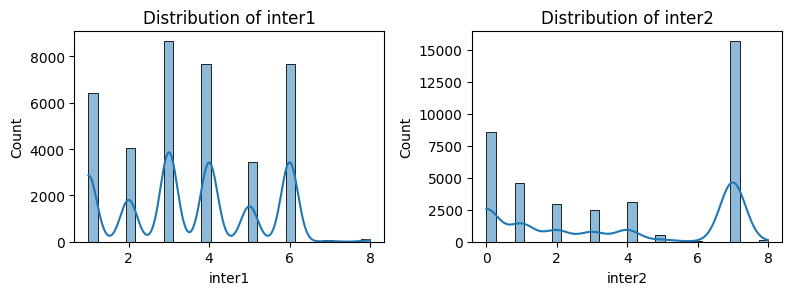

In [512]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame
def draw_histograms(df):
    plt.figure(figsize=(12, 8))  # Adjust size based on number of columns
    for i, col in enumerate(numerical_features_1, 1):
        plt.subplot(3, 3, i)  # Adjust grid size based on the number of columns
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

# Example usage:
draw_histograms(df)


In [513]:
# Separate transformers for categorical and numerical features

from sklearn.impute import SimpleImputer


# trf = FunctionTransformer(np.log1p, validate=True)
trf = StandardScaler()
trf1 = PowerTransformer()
trf2 = FunctionTransformer(np.sqrt, validate=True)
# trf = FunctionTransformer(np.sin)
# Add Polynomial Features
poly=PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

numerical_transformer_1 = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("log", trf),
        ("pwr", trf1),
        # ("poly", poly),
    ]
)
numerical_transformer_2 = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("sqrt", trf2),
        # ("poly", poly),
    ]
)
categorical_transformer_onehot = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)
# Create the categorical transformer for ordinal features with an imputer
categorical_transformer_ordinal = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "ordinal",
            OrdinalEncoder(
                categories=[categories_order[col] for col in categorical_feat_ord],
                handle_unknown="use_encoded_value",
                unknown_value=-1,
            ),
        ),
    ]
)

In [514]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer_onehot, categorical_feat_nom),
        ("cat_1", categorical_transformer_ordinal, categorical_feat_ord),
        ("num", numerical_transformer_1, numerical_features_1),
        ("num_1", numerical_transformer_2, numerical_features_2),
    ]
)

model = XGBRegressor(learning_rate=0.22, n_estimators=500, subsample=1)
# model = LGBMRegressor()
# model = XGBRegressor()
# model = LGBMRegressor(subsample= 0.95, reg_lambda= 0.005623413251903491, reg_alpha= 1.0, num_leaves= 570, n_estimators= 550, min_data_in_leaf= 135, min_child_weight= 0.02, max_depth= 13, learning_rate= 0.015, feature_fraction= 0.85, colsample_bytree= 0.9, cat_smooth= 50, bagging_freq= 9, bagging_fraction= 0.8500000000000001)

# Define the pipeline
pipeline = Pipeline([("preprocessor", preprocessor),("model", model)])

# Fit the pipeline on the training data
pipeline.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['disorder_type',
                                                   'event_type',
                                                   'sub_event_type', 'actor1',
                                                   'actor2', 'admin1', 'admin2',
                                                   'timestamp', 'location',
                                                   'source', 'assoc_actor_1',
                                                   'assoc_actor_2',
                                                   'cluster']),...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.22,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=500, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [515]:
# Save the fitted pipeline as a .pkl file
filename_pkl = "model.pkl"
pickle.dump(pipeline, open(filename_pkl, "wb"))
print(f"Model saved as {filename_pkl}")
# Evaluate the model
y_pred = pipeline.predict(X_test)
print(f"Mean absolute Error: {mean_absolute_error(Y_test, y_pred)}")
r2 = r2_score(Y_test, y_pred)
print(f"R² score: {r2}")
n = len(Y_test)
p = len(X_test.columns)
adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)
print(f"Adjusted R² score: {adj_r2}")

Model saved as model.pkl
Mean absolute Error: 3.1242069048722794
R² score: 0.009719378849046167
Adjusted R² score: 0.00658846923139067
